# Seating Six Feet Apart

### Introduction
As campuses reopen for the fall semester, implementing social distancing measures is a top priority. Students need to maintain 6 feet apart in lecture halls which means that the seating capacity will drop. This is an issue for large and small classes when it comes to room assignments. For ENGRI 1101, we want to enable as many students as possible to attend in-person labs so that they can get immediate help or use the lab computers.  

Make sure the files 'ex1.png', 'floorplan.jpg', 'labclassroom.png', and 'seats_lab.py' are in the same folder as this notebook.

### Import the following

In [1]:
import pandas as pd
import numpy as np
import math, itertools
import matplotlib.pyplot as plt
import networkx as nx
from ortools.linear_solver import pywraplp as OR
import shapely
from shapely.geometry import Polygon, Point

## Part 1: Brainstorming

### Questions
- How can we decide which seats will be used so that the most number of seats are available without breaking social distancing rules?
- How do we turn a classroom layout into something we can solve?

A good strategy for tackling complex problems such as this is to work through small examples. Let's get started!

**Example 1**
Given the following rows of seats, think about how it could be represented as a graph.

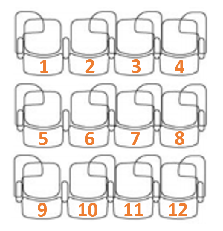

In [2]:
# example 1 image
ex1 = plt.imread('ex1.png')
plt.axis('off')
plt.imshow(ex1);

**Q1:** What are the nodes?  
    
**A:** <font color='blue'>Chairs</font> 

**Q2:** What are the edges? <font color='grey'>(Hint: What relationship b/w the nodes do we care about? Hint 2: Related to distance, but the edges do not have distance attributes.)</font>  

**A:** <font color='blue'>Between chairs that cannot be used simultaneously (less than 6 feet)</font>

Visualize your graph by adding the specific nodes and edges you previously described to the lists V and E. Assume that a chair's 6-foot radius includes 2 chairs to either side, front, back, and the diagonals. For example, if someone occupies seat 7, no one can occupy 5, 6, 8, 3, 11, 2, 4, 10, and 12.

**Q3:** Add the remaining edges to the list and run the cell to visualize it.

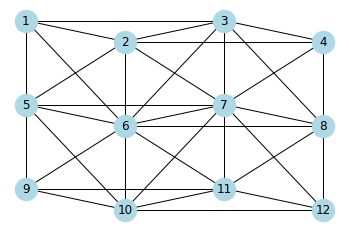

In [3]:
from seat_packing_lab import ex1

V = [1,2,3,4,5,6,7,8,9,10,11,12]
E = [(1,2),(1,3),(1,5),(1,6),(2,3),(2,4),(2,5),(2,6),(2,7),(3,4),(3,6),(3,7),(3,8),(4,7),(4,8),
     (5,6),(5,7),(5,9),(5,10),(6,7),(6,8),(6,9),(6,10),(6,11),(7,8),(7,10),(7,11),(7,12),(8,11),(8,12),
     (9,10),(9,11),(10,11),(10,12),(11,12)]

ex1(V, E)

**Q4:** Give a feasible solution from your graph. It does not have to be optimal.  

**A:** <font color='blue'>1,7,9</font>

**Q5:** In general, what will a feasible solution look like?  

**A:** <font color='blue'>A set of nonadjacent nodes</font>

A set of nonadjacent nodes is called an independent set. We will now look for an independent set of maximum cardinality.

## Part 2: Solving

To reiterate, an independent set must only contain nodes that are not adjacent to each other; if nodes joined by an edge are in the same set, then the set is not independent. The solution we want is not just any independent set--we want the one with the maximum cardinality or largest in size. It is possible for there to be more than one *maximum independent set* (MIS). This type of problem, also called maximum independent set, can be written as an integer program. Think about what constraints should be in the integer program to give us the optimal solution while working through the next example.

**Example 2** Find a MIS.

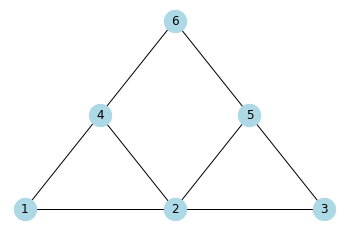

In [4]:
# example 2 graph
from seat_packing_lab import ex2
V2 = [1,2,3,4,5,6]
E2 = [(1,2),(2,3),(1,4),(4,2),(2,5),(5,3),(4,6),(5,6)]
ex2(V2, E2)

**Q6:** Which nodes are in the maximum independent set? (This example has an unique MIS.)  

**A:** <font color='blue'>1,3,6</font>

**Q7:** What are some strategies you tried or patterns you noticed when getting to the answer?  

**A:** <font color='blue'>Will vary</font>

Now, you are ready to write out the integer program.  

Hint: For the edge (1, 2) either 1 or 2 or neither are in the MIS. For the triangle formed by nodes 1, 2, and 4, at most one of the three are in the MIS. The edge example suggests a constraint like $x_1 + x_2 \leq 1$ where $x_1$ = {0 if node 1 not in MIS, 1 if in MIS} and $x_2$ likewise for node 2. The triangle constraint would be $x_1 + x_2 + x_4 \leq 1$.

**Q8:** Is the triangle constraint necessary or redundant?
    
**A:**

**Q9:** Finish the defining the model below

In [5]:
# a model for selecting the most seats
# 'nodes' is a list of chairs, 'edges' is a list of (chair,chair) tuples that are too close
def MIS(nodes,edges,solver):
    
    # define model
    m = OR.Solver('maxIndSet', solver)
    
    # DEFINE DECISION VARIABLES
    x = {} # node i is in the maximum independent set is 1, else 0
    for i in nodes:
        x[i] = m.IntVar(0, 1, ('%s' % (i)))
    
    # DEFINE OBJECTIVE FUNCTION
    m.Maximize(sum(x[i] for i in nodes))
        
    # DEEFINE CONSTRAINT(S)
    for edge in edges:
        m.Add(x[edge[0]] + x[edge[1]] <= 1)

    m.Solve()
    
    # display solution
    sol = {}
    for i in nodes:
        sol.update( {x[i].name() : x[i].solution_value()} )
    print('Total seats:', m.Objective().Value())
    
    return sol

In [6]:
# solve example 1
MIS(V, E, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 4.0


{'1': 1.0,
 '2': 0.0,
 '3': 0.0,
 '4': 1.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 1.0,
 '10': 0.0,
 '11': 0.0,
 '12': 1.0}

**Q10:** Verify that the ILP solution is indeed valid and optimal.

**A:**

**NOTE:** A clique is a set of nodes such that an edge exists for any pair of nodes in the clique. In example 1, {1,2,5,6}, {5,6,9,10}, {3,4,7,8}, and {7,8,11,12} are all the cliques. The union of them is the entire node set. For any clique, at most one node can be picked to be in an independent set; therefore, we have an upper bound of 4 on the cardinality of any independent set in example 1.

In [7]:
# solve example 2
MIS(V2, E2, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 3.0


{'1': 1.0, '2': 0.0, '3': 1.0, '4': 0.0, '5': 0.0, '6': 1.0}

## Part 3: Solving the Actual Data

All we are given at the start is a plain room layout like this one:

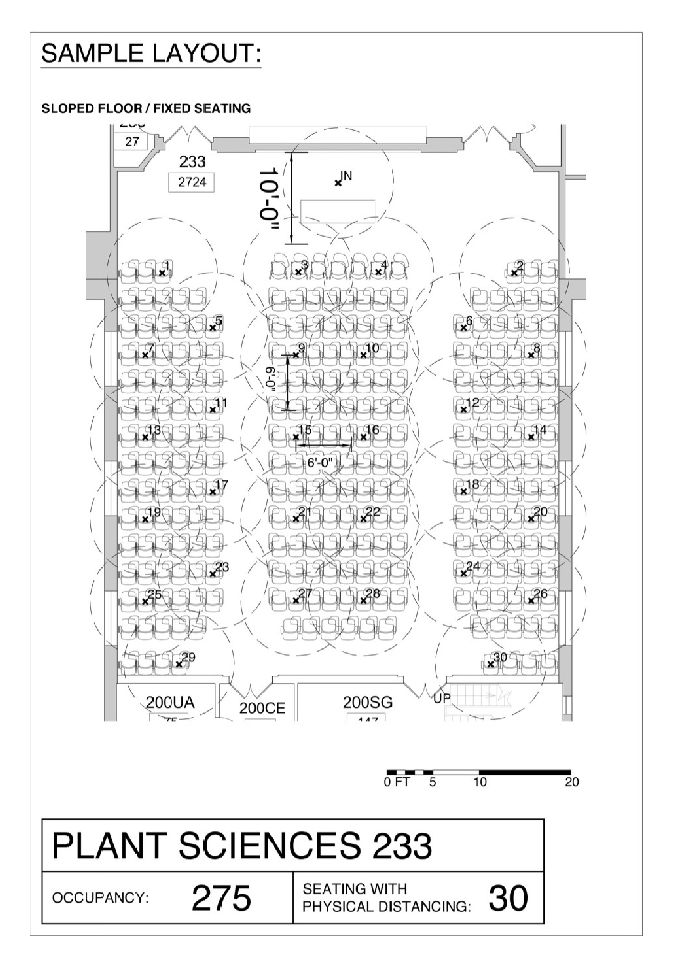

In [8]:
# show original room image
room = plt.imread('floorplan.jpg')
plt.subplots(dpi=300)
plt.axis('off')
plt.imshow(room);

The following is the same room layout with chairs and their center point redrawn on top. The drawings are done using the shapely package installed at the beginning. For the exact code, check out the ex_room() function in *seats_lab.py*.

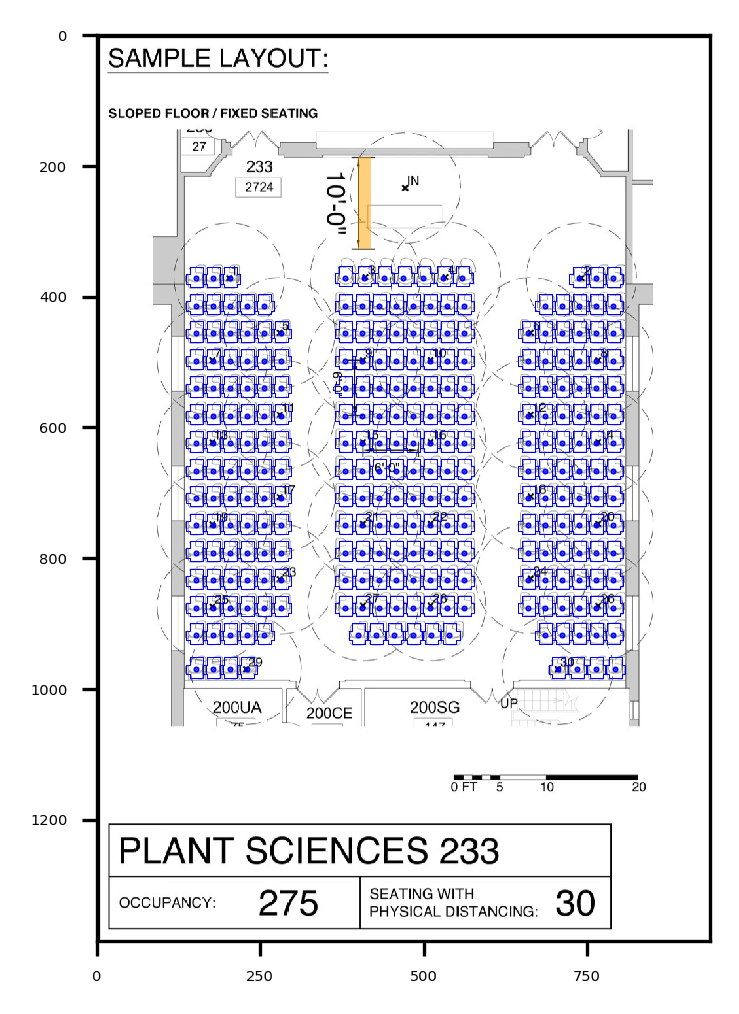

In [9]:
# add drawings
from seat_packing_lab import ex_room
polys, points = ex_room()

A brief overview:
- The layout image is imported.
- We find the location of each chair (manually here but can also use computer vision).
- Distances are in pixels, so we calculate the scale using the orange bar which we know is 10 feet as reference.
- Blue chairs and points are plotted onto the image.

To transform into a graph, we determine the edges by making a list of neighbors for each node. The guideline is that the distance between the central point of the original chair and the *boundary* of a potential 'neighbor' chair is no more than 85 pixels (6'). Read through and run the cell below.

In [10]:
# (code by Sander Aarts)

# define a dataframe of Polygons and Points
df = pd.DataFrame(list(zip(polys, points)), 
               columns =['polygon', 'point'])

# generate edges from distances
df['neighbors'] = None # list of neighbors for each node

edgelist = list()      # overall list of (directed) edges

for i in range(df.shape[0]):
    neighbors = list()     # get empty list
    for j in range(df.shape[0]):
        if (i != j):
            dist = df['polygon'][j].distance(df['point'][i])
            if (dist <= 85.0):    # 85 pixels = 6 feet
                neighbors.append(df.index[j])
                edgelist.append((i,j))
    if (len(neighbors) > 0):
        df['neighbors'][i] = neighbors

With the graph ready, it is time to use the integer program we wrote previously.

In [11]:
# solve for room
sol = MIS(df.index.values, edgelist, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 32.0


This is a 2 seat (6.66%) improvement from the previous solution!

We can update our dataframe and see what the solution looks like after its "Cinderella" moment.

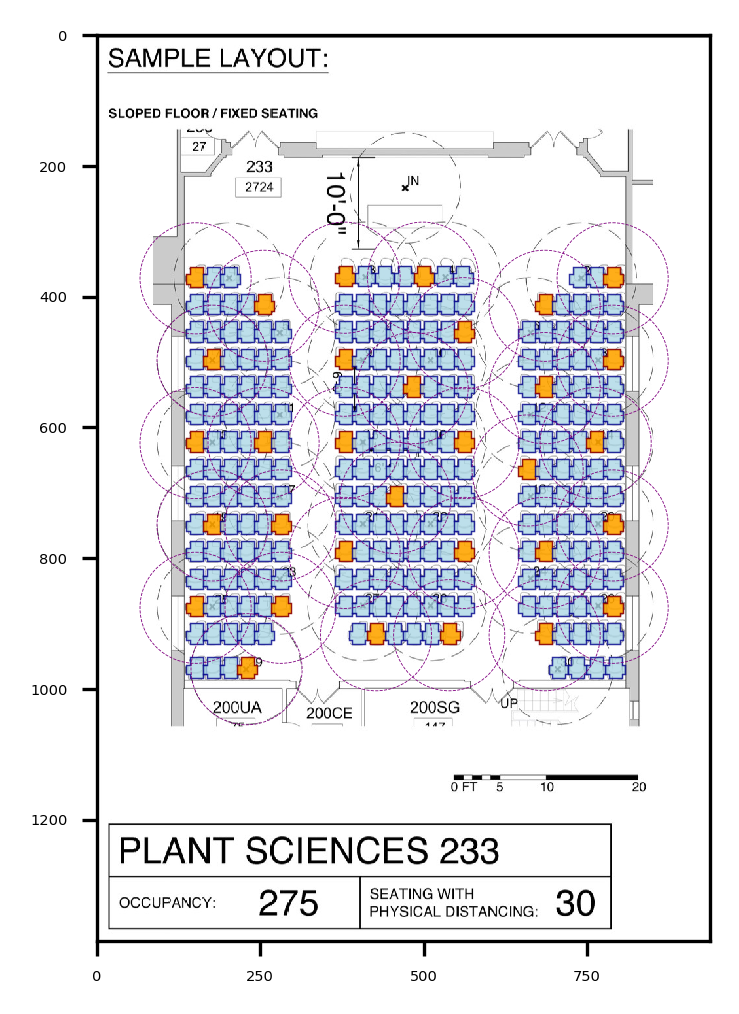

In [12]:
# show solution on room
from seat_packing_lab import ex_room_sol
ex_room_sol(df, sol)

## Challenge

It was mentioned in the introduction that ENGRI 1101 wanted to maximize lab classroom seating. Unlike in lecture halls, the chairs have wheels and can be moved. How will you approach this problem?

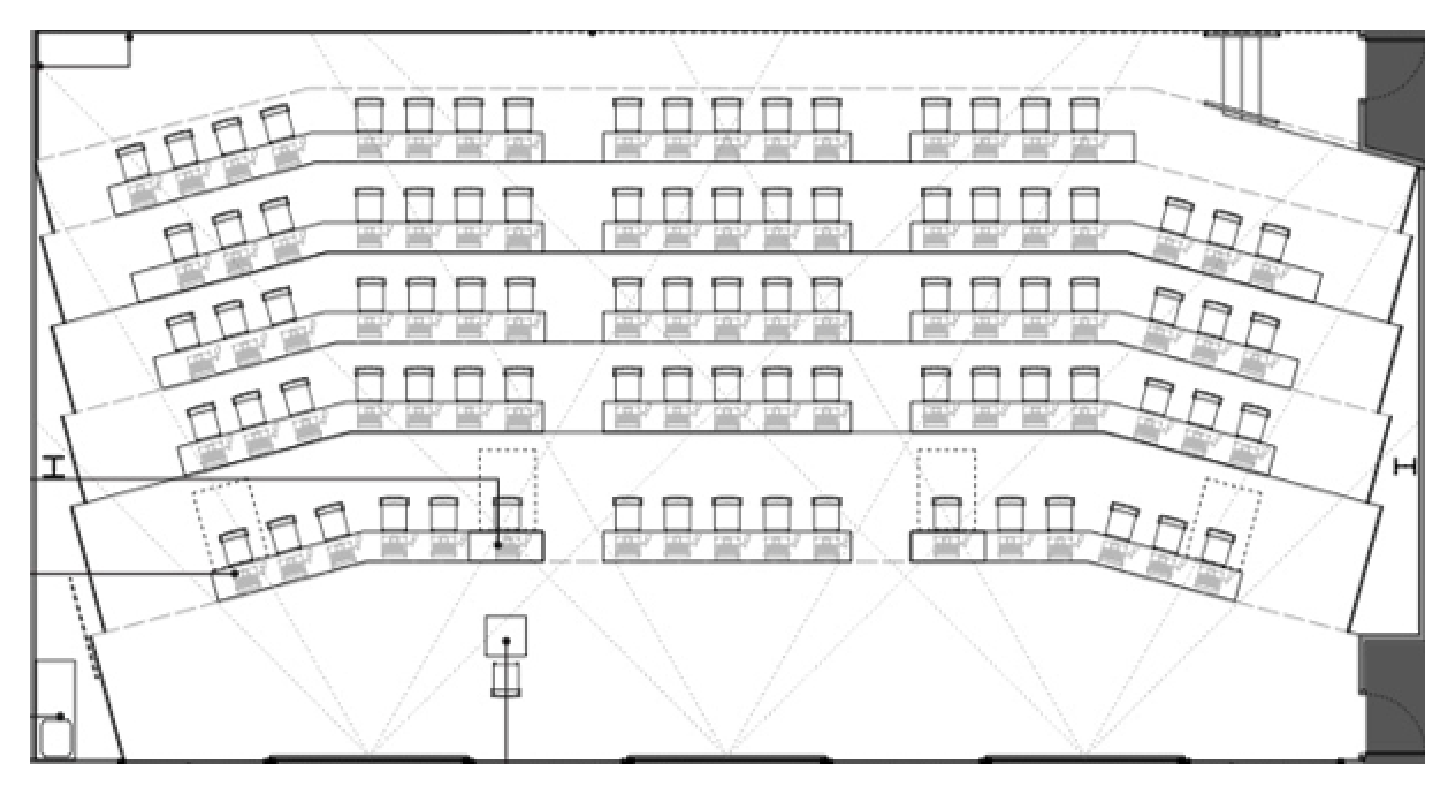

In [13]:
# show Rhodes 571
room = plt.imread('labclassroom.png')
plt.subplots(dpi=300)
plt.axis('off')
plt.imshow(room);

Imagine that all the chairs in Rhodes 571 are taken outside the room and brought back one at a time. The tables are fixed in place. (Ignore the laptops since they are movable.) Where can you place each chair that is brought back?

**Q11:** Will there be fewer or more nodes than chairs currently in the image?  
**A:** <font color='blue'>More</font>

**Q12:** Describe where there might be nodes. Are they close or far apart?  
**A:** <font color='blue'>Nodes will be super close together where there are tables</font>

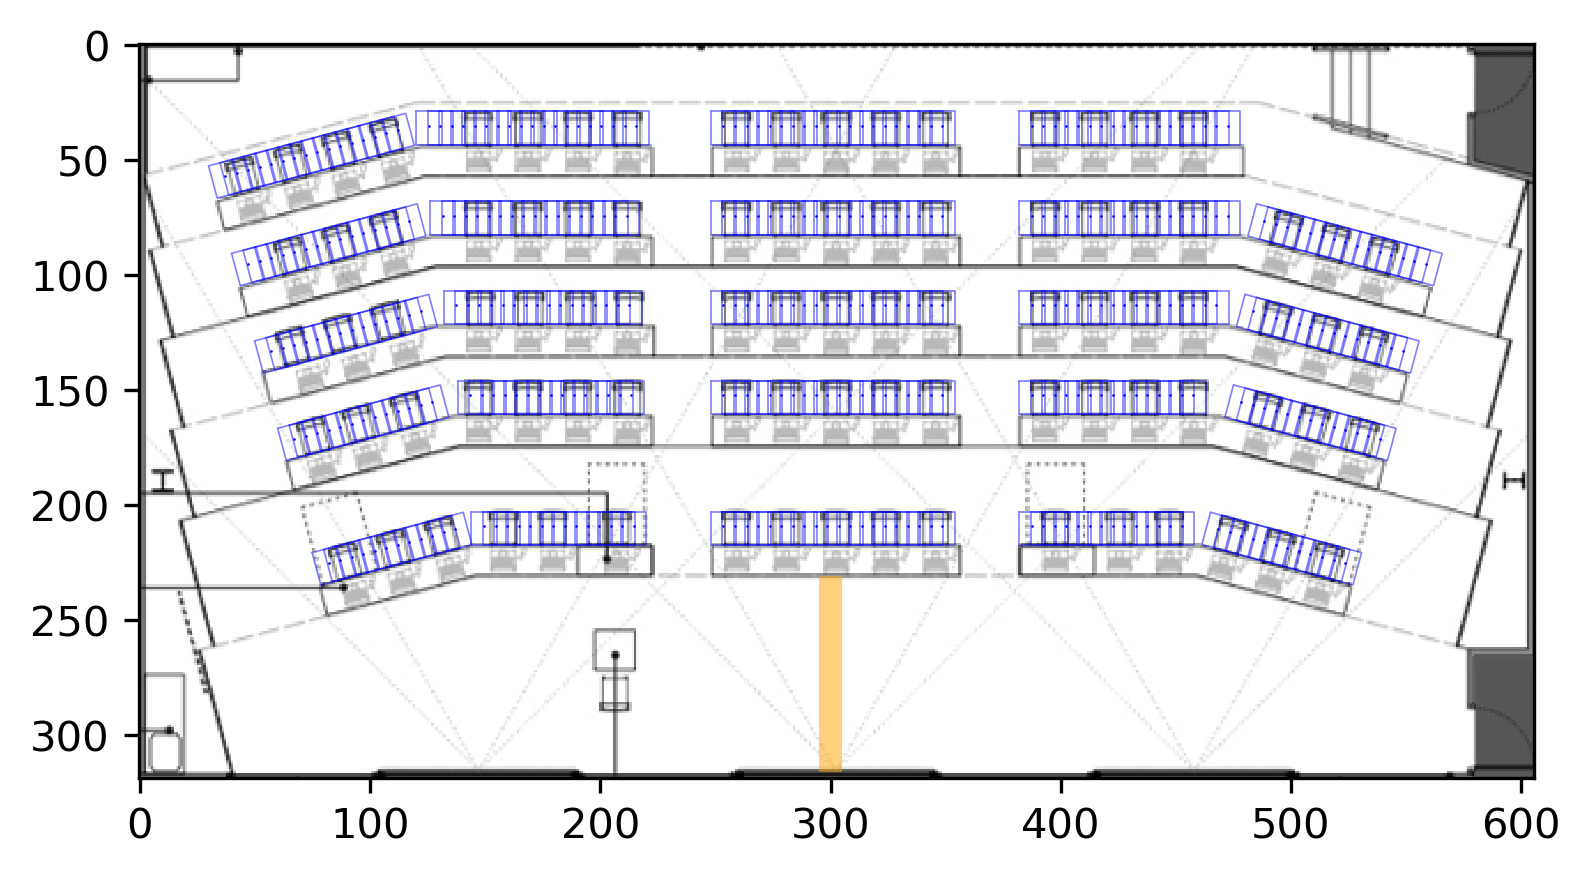

In [14]:
# add drawings
from seat_packing_lab import ex_lab
polys2, points2 = ex_lab()

Is this what you pictured? Each rectangle represents a possible chair placement. The distance between these possible chair placements is arbitrary. In reality, there are an infinite number of chair placements but then the problem would be too big. The arbitrary distance used was a good balance between accuracy and the problem size. Run the next cell to see how many nodes and edges we have here.

In [15]:
# (code by Sander Aarts)

# define a dataframe of Polygons and Points
df2 = pd.DataFrame(list(zip(polys2, points2)), 
               columns =['polygon', 'point'])

# generate edges from distances
edgelist2 = list()      # overall list of (directed) edges

for i in range(df2.shape[0]):
    for j in range(df2.shape[0]):
        if (i != j):
            dist = df2['polygon'][j].distance(df2['point'][i])
            if (dist <= 51):    # 51 pixels = 6 feet
                edgelist2.append((i,j)) # add edge if seat is too close

print('There are %d nodes and %d edges.' % (df2.shape[0], len(edgelist2)))

There are 387 nodes and 13793 edges.


Even a problem this size, our solvers can solve it.

In [16]:
# solve for room
sol2 = MIS(df2.index.values, edgelist2, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Total seats: 27.0


22 is the capacity if chairs are not moved. 27 is a <font color='orange'>22.7%</font> increase!

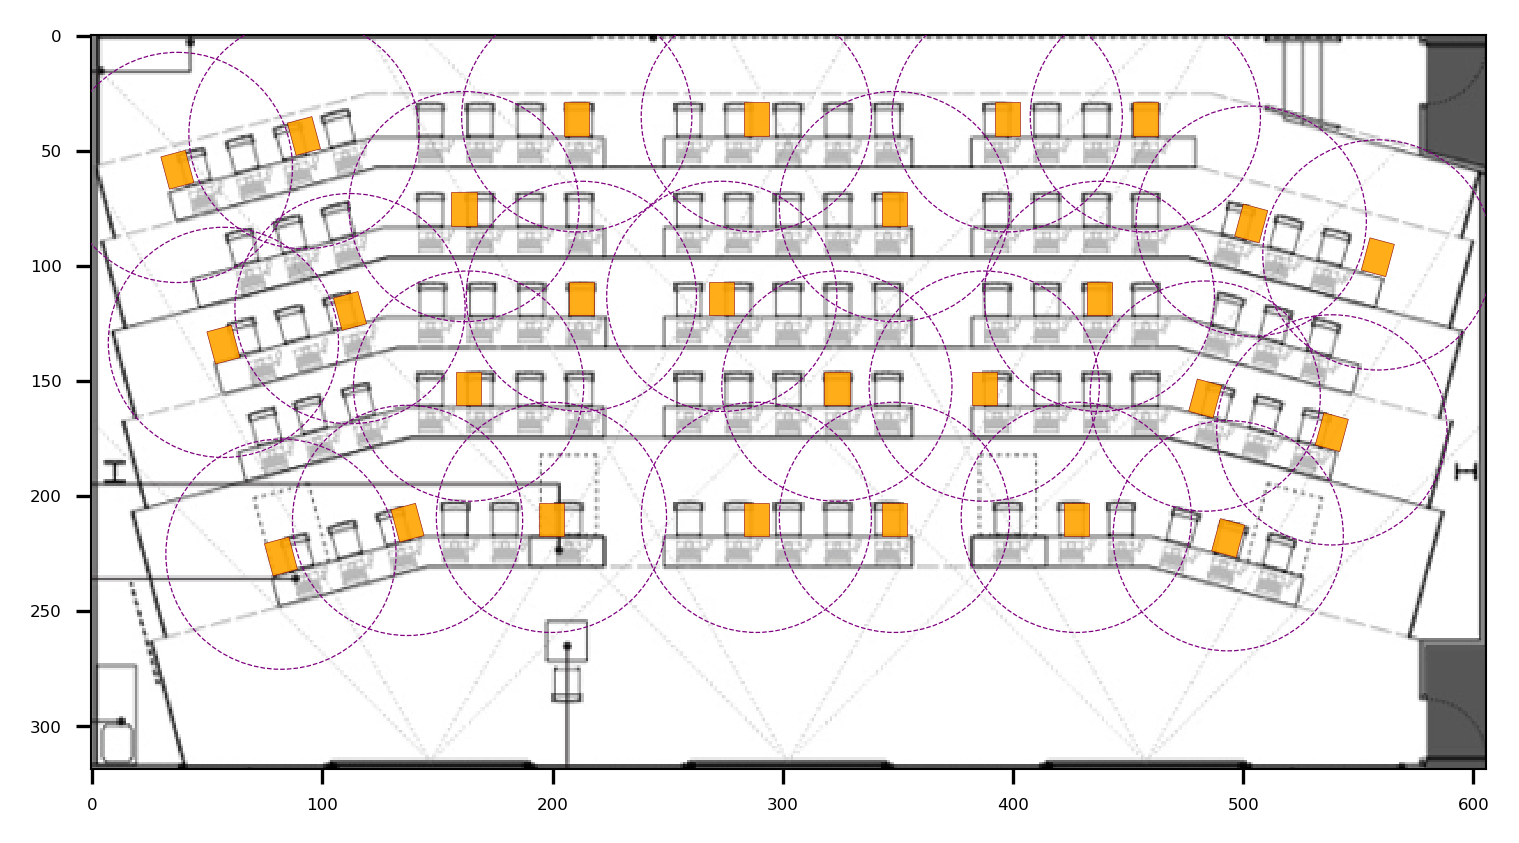

In [17]:
# show solution on room
from seat_packing_lab import ex_lab_sol
ex_lab_sol(df2, sol2)

Congratulations! You just got a taste of the actual process used to figure out 6 feet apart seating configurations for Cornell (and it was done by previous ENGRI 1101 students too!).